In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
from tqdm.auto import tqdm
from Comparative_Analysis import Sequence_Analysis_Routines as sar
from Comparative_Analysis import Utilities as util
from Comparative_Analysis import Alignment as align
from Comparative_Analysis import Blast_Functions as blastfn
import random
import copy
from joblib import Parallel, delayed
import os
import shutil
import subprocess
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.Align.Applications import MuscleCommandline
import re
import shutil
from IPython import display

In [4]:
full_run = True
project_dir = 'D:/Project_Data/Project_8'
datasets_dir = project_dir + '/Datasets'
output_dir = project_dir + '/RScape_Local_Run_2'
wsl_output_loc = util.wslname(output_dir)
seq_dir = 'D:/Actinobacteria_Ref_Rep_Lev_Complete'
blast_dir = 'D:/BLAST/actinobacteria_ref_rep_comp'
blast_db_name = 'actinobacteria_ref_rep_comp'
num_cores = 16
core_numbers = list(range(1, num_cores+1))
reference_species_filename = 'GCF_000195955.2_ASM19595v2_genomic.gbff'
species_list = util.list_files(seq_dir)
species_list = [x for x in species_list if '.gbff' in x]    # Exclude other files generated in directory

In [5]:
filename_dict = {}
def create_filename_dict(num_subsets, subset_num, id_list):
    ids = util.chunk_list(id_list, num_subsets, subset_num)
    temp = []
    for id in (ids):
        for genome_record in SeqIO.parse(seq_dir + '/' + id, "genbank"):
            organism_name = genome_record.annotations['organism']
            accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
            temp.append((accession_ver, id))
    return temp
parallel_output = Parallel(n_jobs=-1)(delayed(create_filename_dict)(num_cores, core_number, species_list) for core_number in core_numbers)
temp = [item for sublist in parallel_output for item in sublist]
for (accession_ver, filename) in temp:
    filename_dict[accession_ver] = filename

In [6]:
with open('D:/Project_Data/Project_8/Output/gene_info_dict.pkl', 'rb') as f:
    gene_info_dict = pickle.load(f) 
with open('D:/Project_Data/Project_8/Output//names_dict.pkl', 'rb') as f:
    names_dict = pickle.load(f) 

##### Generate files containing all genic and intergenic regions in reference organism

In [5]:
features = []
genome_record = next(SeqIO.parse(seq_dir + '/' + reference_species_filename, "genbank"))
full_sequence = str(genome_record.seq)
mycobrowser_df = pd.read_excel(datasets_dir+'/Mycobrowser_Release_4.xlsx')
for i, r in mycobrowser_df.iterrows():
    if r['Strand'] == '+':
        strand = 1
    else:
        strand = -1
    features.append([r['Locus'],r['Start']-1, r['Stop'], strand])
features.sort(key=lambda x: x[1])
feature_info = []
for i, feature in enumerate(features):
    if feature[3] == 1:
        feature_sequence = full_sequence[feature[1]: feature[2]]
    else:
        feature_sequence = util.reverse_complement(full_sequence[feature[1]: feature[2]])
    if feature[1] < feature[2]:  
        if i > 0 and feature[1] > features[i-1][2]:
            utr_coords = (features[i-1][2], feature[1])
            if feature[3] == 1:
                utr_sequence = full_sequence[features[i-1][2]: feature[1]]
            else:
                utr_sequence =  util.reverse_complement(full_sequence[features[i-1][2]: feature[1]])
            utr_length = len(utr_sequence)
        else:
            utr_coords = (0,0)
            utr_sequence = ''
            utr_length = 0
        feature_info.append([feature[0], feature[1], feature[2], feature_sequence, len(feature_sequence), utr_coords[0], utr_coords[1], utr_sequence, utr_length])
genic_intergenic_df = pd.DataFrame(feature_info, columns = ['Locus', 'Start' , 'End', 'Sequence', 'Length', 'Upstream_Start' , 'Upstream_End', 'Upstream_Sequence', 'Upstream_Length'])

In [6]:
temp = pd.read_csv(datasets_dir + '/RFAM_Hits_H37Rv_sorted.csv')
temp_out = []
for i, r in temp.iterrows():
    if r['strand'] == '+':
        start = int(r['seq from'])
        end = int(r['seq to'])
        sequ = full_sequence[start: end]
    else:
        start = int(r['seq to'])
        end = int(r['seq from'])
        sequ = util.reverse_complement(full_sequence[start:end])
    seq_len = len(sequ)
    temp_out.append([r['#idx'], 0, 0, '',0,start, end, sequ, seq_len])
rfam_df = pd.DataFrame(temp_out, columns = ['Locus', 'Start' , 'End', 'Sequence', 'Length', 'Upstream_Start' , 'Upstream_End', 'Upstream_Sequence', 'Upstream_Length'])

In [14]:
rfam_df

,Locus,Start,End,Sequence,Length,Upstream_Start,Upstream_End,Upstream_Sequence,Upstream_Length
0,33,0,0,,0,10887,10960,GGCCTATAGCTCAGGCGGTTAGAGCGCTTCGCTGATAACGAAGAGG...,73
1,40,0,0,,0,11112,11184,GGGCCTTAGCTCAGTTGGTAGAGCACTGCCTTTGCAAGGCAGGGGT...,72
2,84,0,0,,0,25644,25726,GGCGAGTGGCGGAATGGCAGACGCGCTGGCTTCAGGTGCCAGTGTC...,82
3,82,0,0,,0,79204,79294,TGACGCGATGTGGGAGAACCTCCATGTCGAGGCGCCGTAGGAGCAA...,90
4,91,0,0,,0,80218,80316,AGAGCCAGATACGGTGAAAGTCGCACGTCCGGTTCGAAGGGCGGCC...,98
...,...,...,...,...,...,...,...,...,...
87,81,0,0,,0,4168345,4168430,GAGGATTCGCCTAGTGGCCTATGGCGCTCGCCTGGAACGCGGGTTG...,85
88,71,0,0,,0,4199131,4199217,GGTGGCGTGTCCGAGCGGCCTAAGGAGCACGCCTCGAAAGCGTGTG...,86
89,56,0,0,,0,4216865,4216937,GCGCCCGTAGCTCAACGGATAGAGCATCTGACTACGGATCAGAAGG...,72
90,76,0,0,,0,4216968,4217056,GGAGGCGTGCCAGAGCGGCCGAATGGGGCTCACTGCTAATGAGTTG...,88


##### Run HMMER and INFERNAL iteratively

In [90]:
genic_test = genic_df[genic_df.Locus.isin(['Rv0756c'])]    # True downstream gene
intergenic_test = intergenic_df[intergenic_df.Locus.isin(['Rv0757'])]   # Annotation order upstream gene

In [91]:
hmmer_eval =  1e-10
hmmer_eval2 = 1e-5
query_file = 'genic_region.faa'
hm_model_file = 'hmm.hmm'
for i, r in genic_test.iterrows():
    if r['Length'] >= 60:
        sequence_list = [[r['Locus'], r['Sequence']]]
        locus_id = r['Locus']
        print(locus_id)
        results_dir = output_dir + '/' + locus_id
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)
        util.produce_fasta_file(sequence_list, results_dir + '/' + query_file)

        blastfn.nhmmer_search_sequence(results_dir, query_file, datasets_dir, 'full_sequences.faa', 'align_0.sto', 'output.txt', 'hsummary_0.txt', hmmer_eval) 
        if not os.path.exists(results_dir +'/hsummary_0.txt'):
            continue
        blastfn.align_keep_top_hit_per_species(results_dir, 'hsummary_0.txt', 'align_0.sto', 'align_bh_0.sto', 'HMMER', hmmer_eval)
        
        #for i in range(3):
        #    if i == 2:
        #        heval = hmmer_eval2
        #    else:
        #        heval = hmmer_eval
        #        blastfn.hmmer_build(results_dir, 'align_bh_'+str(i)+'.sto' ,hm_model_file)
        #        blastfn.nhmmer_search_model(results_dir, hm_model_file, datasets_dir, 'full_sequences.faa', 'align_'+str(i+1)+'.sto', 'output.txt', 'hsummary_'+str(i+1)+'.txt', heval)      #seq_dir, 'full_sequences.faa'
        #        blastfn.align_keep_top_hit_per_species(results_dir, 'hsummary_'+str(i+1)+'.txt', 'align_'+str(i+1)+'.sto', 'align_bh_'+str(i+1)+'.sto', 'HMMER', heval)

Rv0756c


100%|██████████| 1/1 [00:00<?, ?it/s]


In [92]:
def find_features(accession, stop, start):
    output_values = []
    for feature_info in gene_info_dict[accession]:
        start_f = int(feature_info[1])
        stop_f = int(feature_info[2])
        if stop_f - start_f  > 100000:   #Something wrong!
            continue
        start_1 = min(stop, start)
        stop_1 = max(stop, start)
        if stop_1 > start_f and start_1 < stop_f:
            overlap = (min(stop_f, stop_1) - max(start_f, start_1)) / (stop_1 - start_1)
            output_values.append((feature_info, overlap))
    return output_values

In [93]:
homolog_hits = []
with open(output_dir + '/' + locus_id + '/hsummary_0.txt', 'r') as f:  
    for l in f:
        if (not ('#' in l)):
            a = l.split()
            accession = a[0]
            species = names_dict[a[0]]
            seq_from = int(a[6])
            seq_to = int(a[7])
            if a[11] == '+':
                strand = 1
            else:
                strand = -1
            e_value = float(a[12])
            start = min(seq_from,seq_to) - 1
            stop = max(seq_from, seq_to)
            if e_value < 1e-10:
                for feature in (find_features(accession, start, stop)):
                    if feature[1] > 0.9 and not (feature[0][0][-2:] == 'IG'):
                        homolog_hits.append((accession, filename_dict[accession], start, stop, strand, e_value))
                        break

In [94]:
def create_upstream_search_regions(num_subsets, subset_num, data_list):
    data_subset = util.chunk_list(data_list, num_subsets, subset_num)
    temp = []
    for (accession, filename, start, stop, strand, e_value) in (data_subset):
        for genome_record in SeqIO.parse(seq_dir + '/' + filename, "genbank"):
            full_sequence = str(genome_record.seq)
            if strand == 1:
                upstream_sequence = full_sequence[max(0, start - 1000): start]
            else:
                upstream_sequence = util.reverse_complement(full_sequence[stop: (stop+1000)])
            temp.append((accession, upstream_sequence))
    return temp
parallel_output = Parallel(n_jobs=-1)(delayed(create_upstream_search_regions)(num_cores, core_number, homolog_hits) for core_number in core_numbers)
temp = [item for sublist in parallel_output for item in sublist]

In [95]:
util.produce_fasta_file(temp, output_dir + '/upstream_regions.faa')  

100%|██████████| 189/189 [00:00<00:00, 47143.83it/s]


In [96]:
for (accession, filename, start, stop, strand, e_value) in homolog_hits:
        for genome_record in SeqIO.parse(seq_dir + '/' + filename, "genbank"):
            full_sequence = str(genome_record.seq)
            print(accession, filename, start, stop, strand, e_value)
            if strand == 1:
                upstream_sequence = full_sequence[max(0, start - 1000): start]
            else:
                upstream_sequence = util.reverse_complement(full_sequence[stop: (stop+1000)])
            print(upstream_sequence)
        break

NC_000962.3 GCF_000195955.2_ASM19595v2_genomic.gbff 850740 851466 -1 4.6e-210
GCCACCAGGATCAGCGTGGCTGCGACCAGGCGTACCCGTAGGGGCAGCCTTCCTCGAAGGTGTCTGGCCATTGCCGCGTTCTCCTCGGGCTGCCGATCCGATTAACTACCAAGACTCATCGAGGCTCCCGCAGTACGTAGCCCACCCCGCGCAGCGTGTGCAGCAGCCGCTTCTCCCCAGTGTCGATCTTGCGGCGCAGATACGACACGTAGGACTCGACGACGTTGACATCACCACCGAAGTCGTAGCGCCAAACGTGGTCGAGAATCTTAGGCTTGCTCAGCACGGTGCCCGCGTTGATCACGAAATAGCGCAGCAGGGTGAATTCGGTGGGCGACAGCGACACCGGTTGGCCCGCCTTCCACACTTCGTGGGTCTCCTCGTCGAGCTCGATATCGGCGAACGTCAGTCGAACATTACGTGGTTCCTTGTTGCCCTTGCCCGCGCGTCGCAGGATGACCCGCAGCCTGGCCACGACCTCCTCCAAACTGAAGGGCTTTGTCACATAGTCGTCACCACCCAGGGTCAGACCCGCGATCTTGTCCTGTAGCGAGTCACGGGCCGTCAGGAACAACGCCGGGGCATCGATGCCGTCGGCGCGCAGCCGGCGCAGCACCCCAAAGCCGTCCATCCCGGGCATCATCACATCGAGGATCACCGCGTCCGGCCGGGTTTCCCGGGCCCGATCCAGCGCCTGTGCCCCGTTGGTCGCGGTGTAGACTTCAAAGCCCTGGAACTTGAGGCTCACCGACAGCAGTTCAACGATGTTGGCCTCATCATCGACCACGAGGACACGAGCCTCCGGTGTGGTGTTTTCGCCTGGGGTTCCCGCCGTCACGAGATCAACCCCTTTCCGCATTGGTTGAACGTTACCTTCACAGTCATTGTGTAATTCCTGAAAGCTCGTTGCCAGTAGTCTGCT

In [97]:
hmmer_eval =  1e-10
hmmer_eval_2 = 1e-5
infernal_eval = 1e-5
query_file = 'intergenic_region.faa'
hm_model_file = 'hmm.hmm'
cm_model_file = 'cm.cm'
for i, r in intergenic_test.iterrows():
    if r['Length'] >= 0:
        sequence_list = [[r['Locus'], r['Sequence']]]
        locus_id = r['Locus']
        print(locus_id)
        results_dir = output_dir + '/' + locus_id + '_IG'
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)
        util.produce_fasta_file(sequence_list, results_dir + '/' + query_file)

        blastfn.nhmmer_search_sequence(results_dir, query_file, output_dir, 'upstream_regions.faa', 'align_0.sto', 'output.txt', 'hsummary.txt', hmmer_eval) 
        if not os.path.exists(results_dir +'/hsummary.txt'):
            continue
        blastfn.align_keep_top_hit_per_species(results_dir, 'hsummary.txt', 'align_0.sto', 'align_bh_0.sto', 'HMMER', hmmer_eval)
        for i in range(4):
            blastfn.hmmer_build(results_dir, 'align_bh_'+str(i)+'.sto' ,hm_model_file)
            blastfn.nhmmer_search_model(results_dir, hm_model_file, output_dir, 'upstream_regions.faa', 'align_'+str(i+1)+'.sto', 'output.txt', 'hsummary_'+str(i+1)+'.txt', hmmer_eval_2)      #seq_dir, 'full_sequences.faa'
            blastfn.align_keep_top_hit_per_species(results_dir, 'hsummary_'+str(i+1)+'.txt', 'align_'+str(i+1)+'.sto', 'align_bh_'+str(i+1)+'.sto', 'HMMER', hmmer_eval_2)


        blastfn.infernal_build_and_calib(results_dir, 'align_bh_4.sto' ,'cm_1.cm', False)
        blastfn.infernal_search(results_dir, 'cm_1.cm', output_dir, 'upstream_regions.faa', 'search_1.sto', 'search_hits_1.txt', 'summary_1.txt', infernal_eval) 
        if os.path.getsize(results_dir + '/search_hits_1.txt') > 1e7:
            continue
        blastfn.align_keep_top_hit_per_species(results_dir, 'summary_1.txt', 'search_1.sto', 'search_bh_1.sto', 'INFERNAL', infernal_eval)
        blastfn.run_rscape(results_dir, 'search_bh_1.sto', 'rscape_1')

        #2
        blastfn.infernal_build_and_calib(results_dir, 'rscape_1.cacofold.R2R.sto' ,'cm_2.cm')
        blastfn.infernal_search(results_dir, 'cm_2.cm', output_dir, 'upstream_regions.faa', 'search_2.sto', 'search_hits_2.txt', 'summary_2.txt', infernal_eval) 
        if os.path.getsize(results_dir + '/search_hits_2.txt') > 1e7:
            continue
        blastfn.align_keep_top_hit_per_species(results_dir, 'summary_2.txt', 'search_2.sto', 'search_bh_2.sto', 'INFERNAL', infernal_eval)
        blastfn.run_rscape(results_dir, 'search_bh_2.sto', 'rscape_2')

       #3
        #'search_bh_2.sto'
        blastfn.infernal_build_and_calib(results_dir, 'rscape_2.cacofold.R2R.sto' ,'cm_3.cm')
        blastfn.infernal_search(results_dir, 'cm_3.cm', output_dir, 'upstream_regions.faa', 'search_3.sto', 'search_hits_3.txt', 'summary_3.txt', infernal_eval) 
        if os.path.getsize(results_dir + '/search_hits_3.txt') > 1e7:
            continue
        blastfn.align_keep_top_hit_per_species(results_dir, 'summary_3.txt', 'search_3.sto', 'search_bh_3.sto', 'INFERNAL', infernal_eval)
        blastfn.run_rscape(results_dir, 'search_3.sto', 'rscape_3')

Rv0757


100%|██████████| 1/1 [00:00<?, ?it/s]


In [29]:
a = util.list_dirs(project_dir + '/R_Scape_Results_RFAM')
print(len(a))


61


In [11]:
genome_record = next(SeqIO.parse(seq_dir + '/' + reference_species_filename, "genbank"))
product_dict = {}
for feature in genome_record.features:
    if not(feature.type == 'gene'):
        a = feature.qualifiers
        if a.get("locus_tag")!= None and a.get("product")!=None:
            product_dict[a.get("locus_tag")[0]] = a.get("product")[0]

In [8]:
from scipy.stats import chi2

In [9]:
def display_structure(locus):
    if os.path.exists(screen_dir + '/' + locus + '/rscape_3.cacofold.R2R.sto.svg'):
                return display.SVG(filename=screen_dir + '/' + locus + '/rscape_3.cacofold.R2R.sto.svg')


In [12]:
screen_dir = project_dir + '/R_Scape_Results_RFAM_v2'
screen_dir = project_dir + '/R_Scape_Initial_Screen_V2'
screen_dir = project_dir + '/R_Scape_Results_Downstream'
#screen_dir = project_dir + '/R_Scape_Results_RProtein'
seq_ids = util.list_dirs(screen_dir)
for id in seq_ids:
    if os.path.exists(screen_dir + '/' + str(id) + '/rscape_1.cov'):
        with open(screen_dir + '/' + str(id) + '/rscape_1.cov', 'r') as f:  
            num_pairs = 0
            e_values = []
            for l in f:
                if (not ('#' in l)):
                    a = l.split()
                    if len(a) > 3 and abs(int(a[2])-int(a[1])) > 3:    # Exclude covarying pairs less than 3 bp apart)
                        e_values.append(float(a[4]))
                        num_pairs +=1
        if len(e_values) > 0:
            tot = sum([math.log(x) for x  in e_values])
            num = len(e_values)
            combined_e_value = 1-chi2.cdf(-2*tot, 2*num)
        else:
            combined_e_value = 999
        if combined_e_value < 1:
            with open(screen_dir + '/' + str(id) + '/align_bh_2.sto', 'r') as g:  
                species_list = []
                for l in g:
                    if len(l) > 1 and (not ('#' in l)):
                        species_list.append(l.split()[0])
            num_species = len(set(species_list))
            
            #with open(screen_dir + '/' + str(id) + '/search_bh_1.sto', 'r') as g:  
            #    species_list = []
            #    for l in g:
            #        if len(l) > 1 and (not ('#' in l)):
            #            species_list.append(l.split()[0])
            #num_species_2 = len(set(species_list))
            structure_plotted = False
            if os.path.exists(screen_dir + '/' + str(id) + '/rscape_3.cacofold.R2R.sto.svg'):
                structure_plotted = True
                if num_species > 10 and combined_e_value < 1e-5:
                    if id in product_dict:
                        print(id, product_dict[id], num_species, num_pairs, combined_e_value, structure_plotted)
                    
                    
      
    

Rv0210 hypothetical protein 71 5 1.5905356126610926e-06 True
Rv0500 pyrroline-5-carboxylate reductase 242 3 1.7199942858869832e-06 True
Rv2964 formyltetrahydrofolate deformylase 11 10 0.0 True
Rv3198c ATP-dependent DNA helicase UvrD 160 15 0.0 True
Rv3218 hypothetical protein 165 4 2.1118355781890585e-06 True


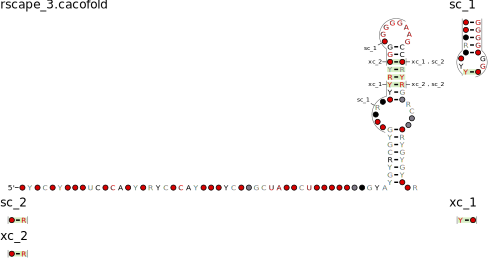

In [307]:
display_structure('Rv0500A')

In [331]:
screen_dir = project_dir + '/R_Scape_Initial_Screen_V2'
screen_dir = project_dir + '/R_Scape_Results_RProtein'
id = 'Rv3517'
if os.path.exists(screen_dir + '/' + str(id) + '/align_bh_1.sto'):
        with open(screen_dir + '/' + str(id) + '/align_bh_1.sto', 'r') as f:  
            i = 0
            for l in f:
                if ('#' in l):
                    a = l.split()
                    if '[subseq' in l:
                        b = a[1].split('/')[0]
                        if '37Rv' in names_dict[b]:
                            print(names_dict[b], l)


Mycobacterium tuberculosis H37Rv #=GS NC_000962.3/1672474-1673297/908-992   DE [subseq from] NC_000962.3/1672474-1673297



In [66]:
names_dict['NC_015848.1']

'Mycobacterium canettii CIPT 140010059'

In [90]:
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

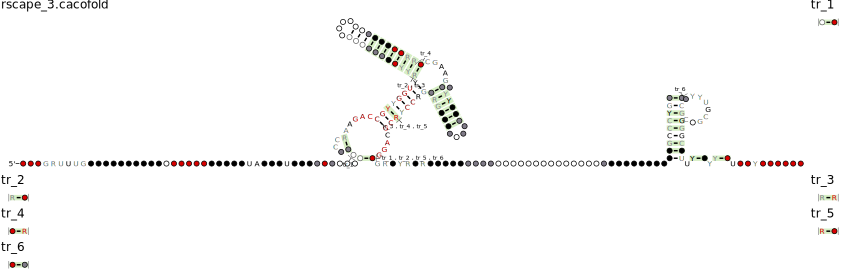

In [110]:
from IPython import display
display.SVG(filename=screen_dir+'/Rv0651'+'/rscape_3.cacofold.R2R.sto.svg')

In [231]:
util.reverse_complement(full_sequence[13016:13133])

'AGCGGACTTGGCGTGAGGGCGTCCGGTTGAACGGCCCCAACGGCGTGTCGGTGTACCGCCACGTGCCCTGGCGGGTCCACAAGGTGTATTCGAGCGACGAGCCGACGTAGCTTCGGG'

In [333]:
for k, v in names_dict.items():
    if 'egmatis' in v:
        print(k, v)

NZ_CP102342.1 Mycolicibacterium smegmatis


In [336]:
with open(datasets_dir + '/filename_dict.pkl', 'rb') as f:
    filename_dict = pickle.load(f) 
filename_dict['NZ_CP102342.1']

'GCF_024600175.1_ASM2460017v1_genomic.gbff'

In [14]:
for k, v in names_dict.items():
    if 'leprae' in v:
        print(k, v)

NZ_CP029543.1 Mycobacterium leprae


In [17]:
filename_dict['NZ_CP029543.1']

'GCF_003253775.1_ASM325377v1_genomic.gbff'